## Homework 11

Carlos Lizama
N17866309

The homework is to replicate Fig. 1 in the paper *"Stochastic Stability in Monotono Economics (2014)"* by Takashi Kamihigashi and John Stachurski.

The problem is the optimal exploitation of a neweable resource. In particular, we want to solve
\begin{equation}
    \mathbb{E} \sum_{t=0}^{\infty} \beta^t u(c_t) \\
    \text{s.t.} \quad y_{t+1} = \xi_{t} f(y_t -c_t) = \xi_{t} f(y_t -\sigma(y_t))
\end{equation}

The utility function is $u(c_t) = 1-\exp(-\theta x^{\gamma})$

The production function is $f(x) = x^{\alpha} l(x)$, where $l(x)$ is the logistic function $l(x) = a + 
\frac{b-a}{1+\exp(-c(x-d))}$

The shock $\xi_t$ is distributed log normal $\log(\xi_t) = \mathcal{N}(-0.1,.2)$ 

Parameters: $a=1, b=2, c=20, d=1,\theta=0.5, \gamma = 0.9$ and $\alpha = 0.5$. The discount factor ranges from $0.945$ to $0.99$

The problem is solved using "fitted policy function iteration". The stationary densities are computed using the look-ahead estimator.

In [ ]:
# load packages
using Distributions
using PyPlot
using CompEcon
using Interpolations

In [2]:
### set functions, parameters and grids ###

# Parameters
a = 1
b = 2
c = 20
d = 1
θ = 0.5
γ = 0.9
α = 0.5
nβ = 10    # feel free to change number of grid points. Plots will adjust later.
β = collect(linspace(.945,.99,nβ))

# functions
u(x) = 1-exp(-θ*x.^γ)
f(x) = x.^α.*l(x)
l(x) = a+(b-a)./(1+exp(-c*(x-d)))
ξ = LogNormal(-0.1,.2)      # the LogNormal function takes parameters μ and σ (not σ^2)

# grids
ny = 120
y = collect(linspace(exp(-1.5), exp(1.5), ny))
ymid = (y[1:end-1]+y[2:end])/2

119-element Array{Float64,1}:
 0.241023
 0.276809
 0.312596
 0.348382
 0.384168
 0.419954
 0.455741
 0.491527
 0.527313
 0.563099
 0.598885
 0.634672
 0.670458
 ⋮       
 4.07015 
 4.10593 
 4.14172 
 4.17751 
 4.21329 
 4.24908 
 4.28486 
 4.32065 
 4.35644 
 4.39222 
 4.42801 
 4.4638  

### Policy function iteration

pick $\sigma \in \Sigma$  
**repeat**  
* evaluate $v_{\sigma}$
* choose $\sigma' \in \Sigma$ such that $\sigma'$ is $v_{\sigma}$-greedy 
* set $\sigma = \sigma'$  

**until** a stopping rule is satisfied


### Look ahead estimator

$$ \psi_n^{*}(y) = \frac{1}{n} \sum_{t=1}^{\infty} p(X_t, y)  \quad y \in S $$

In [3]:
"""
For a given policy σ(y), this function delivers the stochastic kernel associated with this policy function 
P_{σ}(y_t,σ(y_t),y_{t+1}), for a discretized grid for y.
The probability of reaching a certain state in the grid y tomorrow is the measure between the two midpoints at
each side of the grid point.
"""
function findP(y::Array{Float64,1}, σy::Array{Float64,1}, ξ::Distributions.LogNormal)
    ny = size(y)[1]
    ymid = (y[1:end-1]+y[2:end])/2
    P = zeros(ny,ny)    
    for i=1:ny
        ξstar = ymid./f(y[i]-σy[i])     # shock such that in next period y_{t+1} = y[i].
        cdfξy = [cdf(ξ, ξstar); 1]
        cdfξy2 = [0; cdfξy[1:end-1]]
        P[i,:] = cdfξy - cdfξy2         # This is P_{σ}(y_t,y_{t+1})), discretized.
    end
    return P
end

findP (generic function with 1 method)

In [4]:
"""
T_σ operator: for a given policy σ, this function returns v_σ(w), the fixed point of the equation:
T_σ(w) = r_σ + β P_σ w, ie, it returns the value function associated with the policy function given.
"""
function obtain_vσ(β, σy, y, w0, ξ; tol=1e-9)
    P = findP(y, σy, ξ)
    dist = 1
    rσ = u(σy)
    w = w0
    
    while dist>=tol
        wp = rσ + β*P*w
        dist = norm(wp-w,Inf)
        w = wp
    end
    
    return w
    
end

obtain_vσ (generic function with 1 method)

In [5]:
"""
for a given action a, it returns { r(x,a) + β ∫ w(y) P(x, a, dy) }
We later want to look for the optimal policy "a", ie, we want to maximize the above expression.
"""
function operator(β, a, y, w, ξ)
    
    P = findP(y, a, ξ)
    ra = u(a)
    
    return ra + β*P*w
    
end

operator (generic function with 1 method)

In [6]:
"""
For a given function w, this function solves for the w-greedy policy, ie, it finds σ such that
σ in argmax_a { r(x,a) + β ∫ w(y) P(x, a, dy) }
"""
function obtain_greedy_w(β, y::Array{Float64,1}, w::Array{Float64,1}, ξ)
    
    ny = size(y)[1]
    f(a) = operator(β, a, y, w, ξ)
    
    return σgreedy = golden_method(f, zeros(ny), y)[1]     # use golden method from CompEcon
    
end

obtain_greedy_w (generic function with 1 method)

In [7]:
"""
This function computes the policy function iteration. Input: a guess σ and v, β the discount factor, the grid y 
and the distribution of shocks ξ.
"""
function policy_iteration(β, σguess, vguess, y, ξ; tol=1e-6)
    dist = 1

    σ = σguess
    v = vguess
    
    # Loop: Policy function iteration
    while dist > tol
        # compute v_σ
        v = obtain_vσ(β, σ, y, v, ξ)

        # compute σ greedy
        σp = obtain_greedy_w(β, y, v, ξ)

        # update
        dist = norm(σ - σp,Inf)
        σ = σp   

    end
    
    return σ, v
    
end

policy_iteration (generic function with 1 method)

In [8]:
"""
this function computes the stationary distribution given β and the grid for y and the policy function evaluated
at the grid points σ. T is the number of periods to simulate and nlogy is the number of points where the 
stationary distribution will be approximated.
"""

function stationary_dist(β, y, σ, ξ, nlogy=1000; T=100)

    # simulate stationary distribution: the look ahead estimator

    T = 100         
    ξt = rand(ξ, T)           # series of shocks.
    σinterp = interpolate((y,), σ, Gridded(Linear()))

    # create arrays to store time series
    yt = zeros(T)    # vector to store time series
    yt[1] = 1        # initial condition
    σt = zeros(T)    # store optimal policy each period
    σt[1] = σinterp[yt[1]]

    for t=1:T-1
        yt[t+1] = ξt[t+1]*f(yt[t]-σt[t])
        σt[t+1] = σinterp[yt[t+1]]
    end

    # stochastic kernel is given by log(y_{t+1}) = log(ξ_t) + log(f(y_t-σ(y_t))) ∼ N(log(f(y_t-σ(y_t))),s^2)
    logygrid = linspace(-1.5,1.5,nlogy)   # in this grid I evaluate the stochastic kernel.
    ψ = zeros(nlogy)

    for t=1:T-1
        dist = Normal(log(f(yt[t]-σt[t])), .2)
        ψ = ψ + pdf(dist,logygrid)/T
    end
    
    return ψ

end


stationary_dist (generic function with 2 methods)

In [9]:
# this is the block that solves the homework. 
# Here I compute policy functions, value functions and stationary distritributions.

nlogy = 1000      # number of points for grid of log(y) -to plot stationary distributions-
σ = zeros(nβ,ny)
v = zeros(nβ,ny)
ψ = zeros(nβ,nlogy)

for i=1:nβ
    
    # solve using policy function iteration
    σ[i,:], v[i,:] = policy_iteration(β[i], y, y, y, ξ)    # guess for σ=y, guess for v=y as well.

    # compute stationary distriubution
    ψ[i,:] = stationary_dist(β[i], y, squeeze(σ[i,:],1), ξ, nlogy)
    
end 

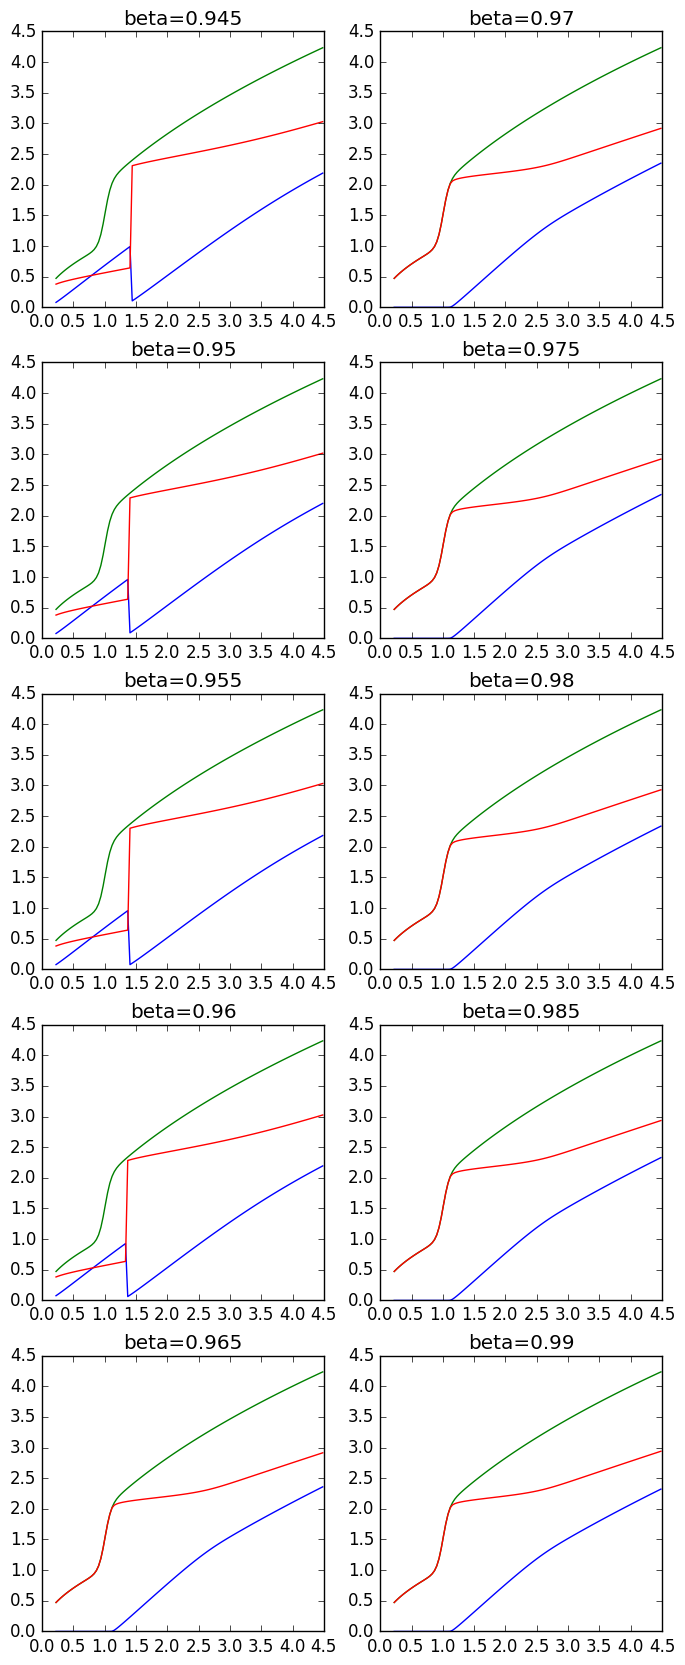

In [10]:
# plot as we did in the lecture.
ncols = 2   # feel free to change number of columns, plots will adjust.
nrows = ceil(Int,nβ/ncols)
fig, axes = subplots(nrows, ncols, figsize=(4*ncols,4*nrows))

for i=1:nβ
    # compute number of row and column. It fills the subplots by columns first.
    poscol = 1+floor(Int,(i-1)/nrows)
    posrow = Int(1+mod(i-1,nrows))
    ax = axes[posrow, poscol]
    βi = β[i]
    ax[:set_title]("beta=$βi")
    ax[:plot](y, squeeze(σ[i,:],1), "b")      # plot policy function
    ax[:plot](y, f(y), "g")                   # plot production function
    ax[:plot](y, f(y-squeeze(σ[i,:],1)), "r") # plot "investment"
end

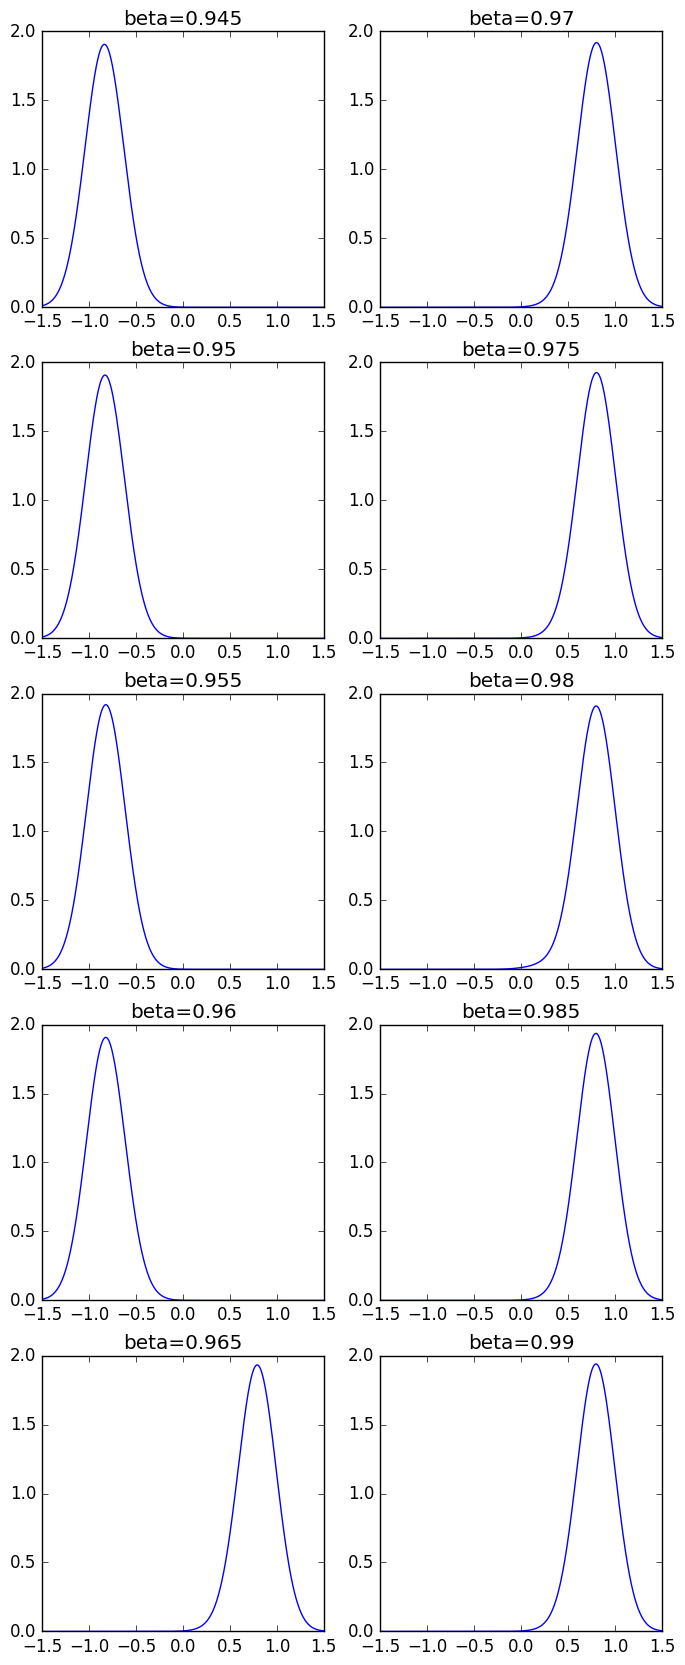

In [11]:
# grid to plot
logy = linspace(-1.5,1.5,nlogy)     # grid for log(y)

ncols = 2
nrows = ceil(Int,nβ/ncols)
fig, axes = subplots(nrows, ncols, figsize=(4*ncols,4*nrows))


for i=1:nβ
    # compute number of row and column. It fills the subplots by columns first.
    poscol = 1+floor(Int,(i-1)/nrows)
    posrow = Int(1+mod(i-1,nrows))
    ax = axes[posrow, poscol]
    βi = β[i]
    ax[:set_title]("beta=$βi")    
    ax[:plot](logy, squeeze(ψ[i,:],1), "b") # plot "investment"
end